# Data Collection

In [3]:
from pathlib import Path

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objs as go
import seaborn as sns
from plotly.subplots import make_subplots
from ydata_profiling import ProfileReport
from yellowbrick.regressor import ResidualsPlot

In [6]:
# you must put the CSV file billets.csv in data directory, cf above cell
data = pd.read_csv("data/billets.csv", sep=";")
data.shape  # data frame dimensions (nb rows, nb columns)

(1500, 7)

In [7]:
from sklearn import linear_model

import statsmodels.formula.api as smf
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats.diagnostic import het_white , normal_ad

In [8]:
data_model = data.loc[lambda dfr: dfr.margin_low.notnull()]

data_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1463 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1463 non-null   bool   
 1   diagonal      1463 non-null   float64
 2   height_left   1463 non-null   float64
 3   height_right  1463 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1463 non-null   float64
 6   length        1463 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 81.4 KB


In [9]:
# Création des variables explicatives et cible:
# X est la liste des variables explicatives et y est la variable cible
X = data_model.loc[:, ["diagonal", "height_left", "height_right", "margin_up", "length"]]  # ou data.drop(["margin_low", "is_genuine"], axis=1)
y = data_model.loc[:, 'margin_low']

In [94]:
X.head()

,diagonal,height_left,height_right,margin_up,length
0,171.81,104.86,104.95,2.89,112.83
1,171.46,103.36,103.66,2.99,113.09
2,172.69,104.48,103.50,2.94,113.16
3,171.36,103.91,103.94,3.01,113.51
4,171.73,104.28,103.46,3.48,112.54


# Train/Test split

In [10]:
# Séparons nos données en un jeu d'entraînement et un jeu de test :
# 30% des données dans le jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Train set - X: {X_train.shape} ; y: {y_train.shape} \nTest set - X: {X_test.shape} ; y: {y_test.shape}")

Train set - X: (1024, 5) ; y: (1024,) 
Test set - X: (439, 5) ; y: (439,)


## Standardisation

In [11]:
# Standardisons les données :

std_scaler = StandardScaler().fit(X_train)  # Standardize features by removing the mean and scaling to unit variance.
X_train_std = std_scaler.transform(X_train)
X_test_std = std_scaler.transform(X_test)

## Ridge 

In [12]:
# On crée un modèle de régression linéaire
ridge = linear_model.Ridge(alpha=1.)

# On entraîne ce modèle sur les données d'entrainement
ridge.fit(X_train, y_train)

# On récupère l'erreur de norme 2 sur le jeu de données test
ridge_error = np.mean((ridge.predict(X_test) - y_test) ** 2)


# On obtient l'erreur quadratique ci-dessous
print(ridge_error)

0.2162136226425013


In [13]:
mse = metrics.mean_squared_error(ridge.predict(X_test), y_test)
rmse = np.sqrt(mse)  # metrics.mean_squared_error(ridge.predict(X_test), y_test, squared=False)
mae = metrics.mean_absolute_error(ridge.predict(X_test), y_test)

mse, rmse, mae

(0.2162136226425013, 0.46498776612132636, 0.35629319455565117)

## Définition d'une fonction d'entrainement

In [16]:
def train_model(model, x_train, y_train, x_test, y_test):
    # On entraîne ce modèle sur les données d'entrainement
    model.fit(x_train, y_train)
    
    # On récupère l'erreur de norme 2 sur le jeu de données train
    error_train = np.mean((model.predict(x_train) - y_train) ** 2)

    # On récupère l'erreur de norme 2 sur le jeu de données test
    error_test = np.mean((model.predict(x_test) - y_test) ** 2)

    # On obtient l'erreur quadratique ci-dessous
    print(f"Model error: {round(error_test, 5)}")
    return {"estimator": model, "error_train": error_train, "error_test": error_test}

In [17]:
# Train and evaluate ridge regression
ridge_error = train_model(model=linear_model.Ridge(alpha=1.),
                          x_train=X_train, y_train=y_train,
                          x_test=X_test, y_test=y_test)

Model error: 0.21621


## Lasso

In [18]:
# Train and evaluate ridge regression
lasso_error = train_model(model=linear_model.Lasso(fit_intercept=True, alpha=1.,),
                          x_train=X_train, y_train=y_train,
                          x_test=X_test, y_test=y_test)

Model error: 0.42698


## Elastic-Net

In [19]:
# Train and evaluate ridge regression
elastic_error = train_model(model=linear_model.ElasticNet(fit_intercept=True, alpha=1., l1_ratio=.5),
                            x_train=X_train_std, y_train=y_train,
                            x_test=X_test, y_test=y_test)

Model error: 0.42698


C:\Users\Larry\anaconda3\Lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


# EXERCICE 1

# EXERCICE 2

- Optimiser les modèles Ridge, Lasso et ElasticNet
- Etudier l'importance des variables dans chaque modèle


A envoyer par mail: 
- Lien github vers le notebook
- Objet: IML ISE - TP1 regression 2024
au plus tard jeudi 18h

## Optimisation du modèle  Ridge et importance des variables

In [101]:
# On va utiliser la fonction GridSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

On va ecrire une fonction qui nous donne les parametre optimums pour les modèles.

Après plusieurs tentatives, on a constaté que le meilleur paramètre alpha se situe entre 0 et 20

In [102]:
def model_optimisation(model, type_scoring, x_train, y_train, range, x_test, y_test, feature_names):
    
    param_grid = {'alpha': range}
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                                     scoring=type_scoring, cv=5, return_train_score=True)
    
    grid_search.fit(x_train, y_train)
    
    print("Meilleur alpha :", grid_search.best_params_)
    print("Meilleur score d'erreur :", grid_search.best_score_)
    # Tracé 

    results_ridge = grid_search.cv_results_
    alphas = results_ridge['param_alpha'].data
    mean_test_errors = -results_ridge['mean_test_score']  # Convertir en MSE positif
    
    # Tracer avec Plotly
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=alphas, y=mean_test_errors, mode='lines+markers', 
                             name='Erreur de test moyenne', line=dict(color='blue')))
    
    fig.update_layout(
        title="Erreur de test en fonction de Alpha",
        xaxis=dict(title="Alpha"),
        yaxis=dict(title="Erreur de test moyenne"),
        template="plotly_white"
    )
    
    fig.show()

    # Récupérer le meilleur modèle et l'entraîner sur l'ensemble des données d'entraînement
    best_ridge_model = grid_search.best_estimator_
    
    # Calculer l'erreur finale sur le jeu de données de test
    y_pred_test = best_ridge_model.predict(x_test)
    test_error = mean_squared_error(y_test, y_pred_test)
    r2 = r2_score(y_test, y_pred_test)  # Calcul du coefficient de détermination
    print("Erreur sur les données de test (MSE) :", test_error)
    print("Coefficient de détermination (R²) sur les données de test :", r2)

    # Importance des variables
    coefficients = best_ridge_model.coef_
    
    if feature_names is None:
        feature_names = [f'Feature {i}' for i in range(len(coefficients))]
    
    # Création d'un DataFrame pour les coefficients et les noms de features
    feature_importance = pd.DataFrame({
        'Variable': feature_names,
        'Importance': np.abs(coefficients)  # Utiliser la valeur absolue pour l'importance
    }).sort_values(by='Importance', ascending=False)

    
    # Visualisation de l'importance des variables
    fig = go.Figure()
    fig.add_trace(go.Bar(
        x=feature_importance['Variable'], 
        y=feature_importance['Importance'],
        name="Importance des variables",
        marker=dict(color='orange')
    ))

    fig.update_layout(
        title="Importance des variables pour le modèle optimisé",
        xaxis=dict(title="Variables"),
        yaxis=dict(title="Importance absolue des coefficients"),
        template="plotly_white"
    )
    
    fig.show()
    return feature_importance


### En utilisant la MSE

Meilleur alpha : {'alpha': 9.494949495002022}
Meilleur score d'erreur : -0.24030135248384904


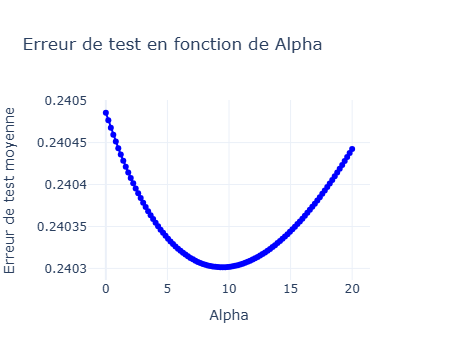

Erreur sur les données de test (MSE) : 0.21612493019996884
Coefficient de détermination (R²) sur les données de test : 0.49381112811597594


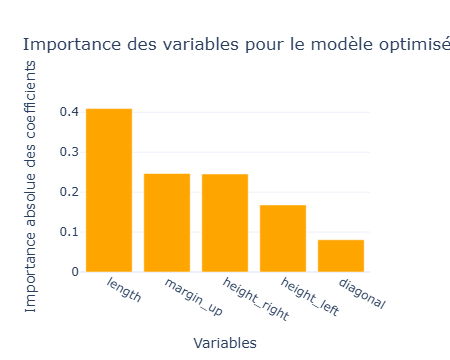

,Variable,Importance
4,length,0.409167
3,margin_up,0.246623
2,height_right,0.245428
1,height_left,0.167951
0,diagonal,0.080679


In [110]:
model_optimisation(linear_model.Ridge(), "neg_mean_squared_error", X_train, y_train, np.linspace(1e-10, 20, 100), X_test, y_test, feature_names=['diagonal', 'height_left', 'height_right', 'margin_up', 'length'])

### En utilisant la MAE

Meilleur alpha : {'alpha': 19.393939393942425}
Meilleur score d'erreur : -0.3816961913723286


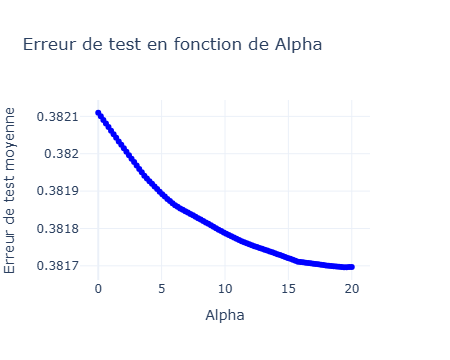

Erreur sur les données de test (MSE) : 0.21626992933689454
Coefficient de détermination (R²) sur les données de test : 0.4934715238441473


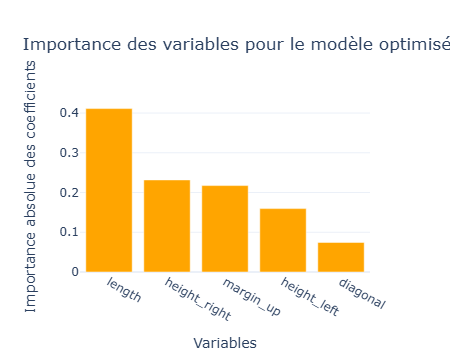

,Variable,Importance
4,length,0.411165
2,height_right,0.231665
3,margin_up,0.217424
1,height_left,0.159472
0,diagonal,0.074427


In [111]:
model_optimisation(linear_model.Ridge(), "neg_mean_absolute_error", X_train, y_train, np.linspace(1e-10, 20, 100), X_test, y_test, feature_names=['diagonal', 'height_left', 'height_right', 'margin_up', 'length'])

### En utilisant R2

Meilleur alpha : {'alpha': 8.686868686925253}
Meilleur score d'erreur : 0.46027795574815433


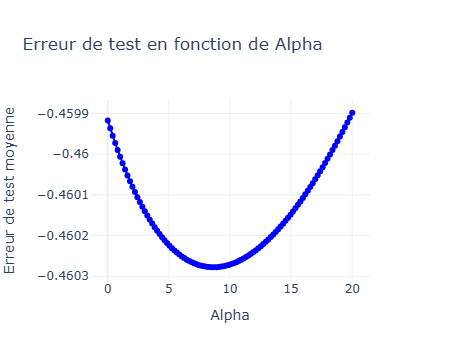

Erreur sur les données de test (MSE) : 0.21612260100189584
Coefficient de détermination (R²) sur les données de test : 0.49381658335958833


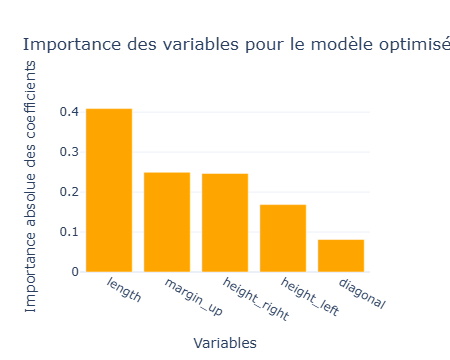

,Variable,Importance
4,length,0.408912
3,margin_up,0.249527
2,height_right,0.246633
1,height_left,0.168677
0,diagonal,0.081241


In [112]:
model_optimisation(linear_model.Ridge(), "r2", X_train, y_train, np.linspace(1e-10, 20, 100), X_test, y_test, feature_names=['diagonal', 'height_left', 'height_right', 'margin_up', 'length'])

#### On peut s'en tenir au résultat obtenu avec la MSE

## Optimisation du modèle Lasso et importance des variables

### Avec la MSE

Ici, on constate que la valeur optimale est très proche de zero

Meilleur alpha : {'alpha': 1e-16}
Meilleur score d'erreur : -0.24048559386935828


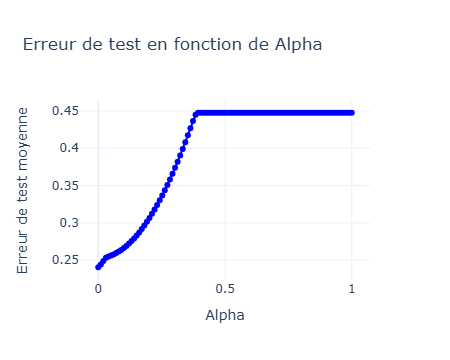

Erreur sur les données de test (MSE) : 0.21624524016354482
Coefficient de détermination (R²) sur les données de test : 0.49352934866238585


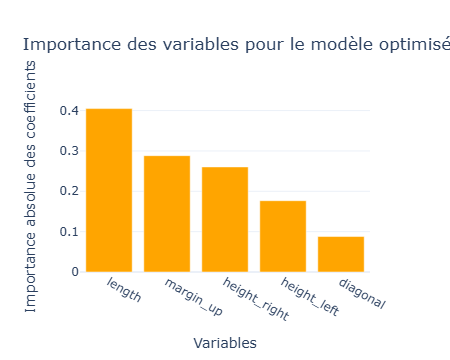

,Variable,Importance
4,length,0.404925
3,margin_up,0.288271
2,height_right,0.260365
1,height_left,0.176682
0,diagonal,0.087867


In [113]:
model_optimisation(linear_model.Lasso(), "neg_mean_squared_error", X_train, y_train, np.linspace(1e-16, 1, 100), X_test, y_test, feature_names=['diagonal', 'height_left', 'height_right', 'margin_up', 'length'])

### Avec la MAE

Meilleur alpha : {'alpha': 1e-16}
Meilleur score d'erreur : -0.3821096775474994


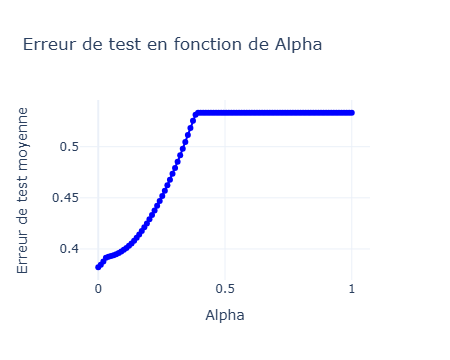

Erreur sur les données de test (MSE) : 0.21624524016354482
Coefficient de détermination (R²) sur les données de test : 0.49352934866238585


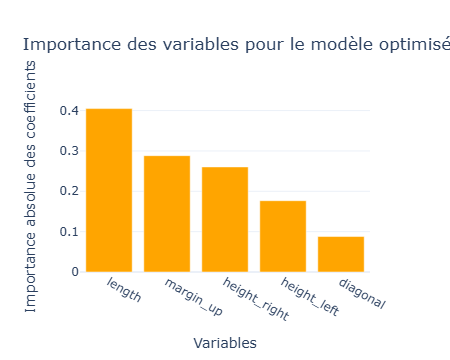

,Variable,Importance
4,length,0.404925
3,margin_up,0.288271
2,height_right,0.260365
1,height_left,0.176682
0,diagonal,0.087867


In [114]:
model_optimisation(linear_model.Lasso(), "neg_mean_absolute_error", X_train, y_train, np.linspace(1e-16, 1, 100), X_test, y_test, feature_names=['diagonal', 'height_left', 'height_right', 'margin_up', 'length'])

### Avec le R2

Meilleur alpha : {'alpha': 1e-16}
Meilleur score d'erreur : 0.45991728947657223


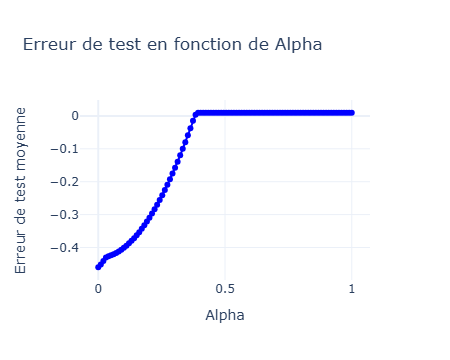

Erreur sur les données de test (MSE) : 0.21624524016354482
Coefficient de détermination (R²) sur les données de test : 0.49352934866238585


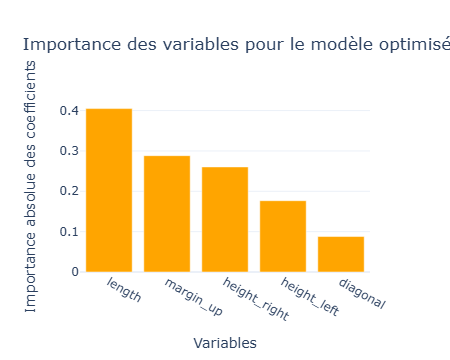

,Variable,Importance
4,length,0.404925
3,margin_up,0.288271
2,height_right,0.260365
1,height_left,0.176682
0,diagonal,0.087867


In [115]:
model_optimisation(linear_model.Lasso(), "r2", X_train, y_train, np.linspace(1e-16, 1, 100), X_test, y_test, feature_names=['diagonal', 'height_left', 'height_right', 'margin_up', 'length'])